In [ ]:
!git clone https://github.com/cgiova/xai_croco.git

Cloning into 'xai_croco'...
remote: Enumerating objects: 3143, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 3143 (delta 2), reused 37 (delta 2), pack-reused 3106
Receiving objects: 100% (3143/3143), 668.97 MiB | 20.55 MiB/s, done.
Resolving deltas: 100% (57/57), done.
Updating files: 100% (3086/3086), done.


In [ ]:
!cd /content/xai_croco

In [ ]:
import sys
sys.path.append('/content/xai_croco')
sys.path.append('/content/xai_croco/XAI_course_2024-main')

In [ ]:
#custom neural networkx models
import neural_networks as ann
#other imports
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize

# Load model and autoencoder

That were trained on different script

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=4, hidden_dim=1024):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim

        # encoder layers
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # decoder layers
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)

In [ ]:
#main model
conv_net = ann.ConvNet()
extra_layer = ann.Extra_layer()
model = nn.Sequential(conv_net, extra_layer)
model.load_state_dict(torch.load('/content/xai_croco/model_checkpoint.pth'))
model.eval()

#autoencoder
autoencoder = Autoencoder(latent_dim=4, hidden_dim=1024)
autoencoder.load_state_dict(torch.load('/content/xai_croco/autoencoder_checkpoint.pth'))
model.eval()

Sequential(
  (0): ConvNet(
    (conv_layers): Sequential(
      (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ReLU()
      (3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
      (4): Dropout(p=0.5, inplace=False)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): ReLU()
    )
    (fc_layers): Sequential(
      (0): Linear(in_features=320, out_features=50, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=50, out_features=10, bias=True)
    )
  )
  (1): Extra_layer(
    (bin): Linear(in_features=10, out_features=2, bias=True)
  )
)

# Load data

In [ ]:
# Specify the target digit for binary classification
batch_size_train = 128
batch_size_test = 1000
target_digit = 9
transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
# Create binary classification train and test loaders
binary_train_loader = DataLoader(ann.BinaryMNIST('mnist_data/', train=True, transform=transform, target_digit=target_digit),
                          batch_size=batch_size_train, shuffle=True)
binary_test_loader = DataLoader(ann.BinaryMNIST('mnist_data/', train=False, transform=transform, target_digit=target_digit),
                         batch_size=batch_size_test, shuffle=True)

In [ ]:
data_iter = enumerate(binary_test_loader)
batch_idx, (data, targets) = next(data_iter)
ones = (targets==1).nonzero()
x = data[ones[0]]

factual = data[ones[17]].clone().detach()
factual.squeeze(0).numpy().shape

(1, 28, 28)

In [ ]:
zeroes = data[targets==0]
zeroes.shape

torch.Size([911, 1, 28, 28])

## LIME

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=995a02f21410932f3adccec868347b04950b1a69d75eb80e58cb6c16166cea7a
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
factual.squeeze(0).squeeze(0).numpy().shape

(28, 28)

In [ ]:
ds = data.numpy()

  0%|          | 0/1000 [00:00<?, ?it/s]

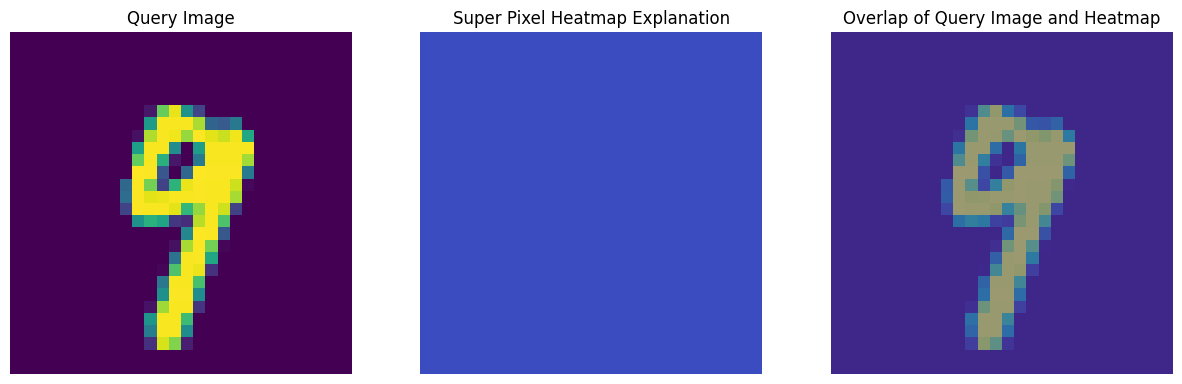

In [117]:
from xailib.explainers.lime_explainer import LimeXAIImageExplainer
from skimage.color import label2rgb, gray2rgb, rgb2gray

# index of the image to explain
instance = data[ones[17]].clone().detach().numpy().squeeze(0).squeeze(0)

# 1) Create the Explainer
lm = LimeXAIImageExplainer(model)

# 2a) Fit the Explainer
lm.fit()

# 2b) Create custom classifier function that takes as input an array of images (the LIME neighbourhood) and return an array of (num_images,num_classes)
# If None will use black_box.predict function
def classifier_fn(images):
    images = torch.tensor(rgb2gray(images/255).reshape(-1,1,28,28)).float()
    #print(images.shape)
    #print(np.argmax(model(images).detach().numpy(),axis=1).reshape(-1,1))
    return np.argmax(model(images).detach().numpy(),axis=1).reshape(-1,1)

# 3) Explain an Instance
explanation = lm.explain(gray2rgb(instance), classifier_fn, num_samples=1000)

# 4) Plot the results
lime_score = explanation.heatmap
lm.plot_lime_values(instance, explanation)

## IntGrad

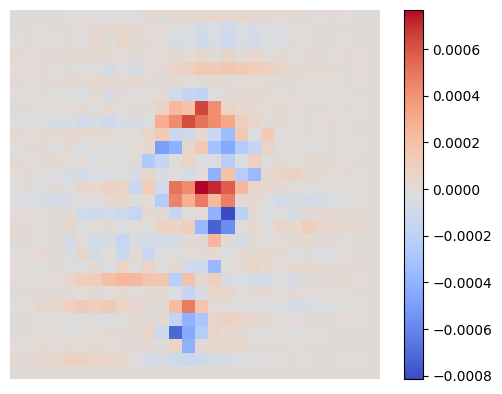

In [ ]:
from xailib.explainers.intgrad_explainer import IntgradImageExplainer

# 1) Create the Explainer
ig = IntgradImageExplainer(model)

# 2) Fit the Explainer
ig.fit()


# 3) Select the image we want to give an explanation for
image = factual.squeeze(0).numpy()

# 4a) Preprocessing function: function that takes as input an image and return the correct format for the black box
def preprocessing(image):
    return torch.tensor(image/255).float()

# 4b) Predict Function of our black box: It needs to take as input the output of preprocessing and return an array of probabilities of classes with shape (-1,num_classes)
def predict(image):
    return model(image.unsqueeze(0))

# 5) Explain an Instance
intgrad_pt_score = ig.explain(image,1, 'black', preprocessing, predict, model_type='pytorch').reshape(28,28)

plt.imshow(intgrad_pt_score,cmap='coolwarm')
plt.colorbar()
plt.axis('off');

## RISE

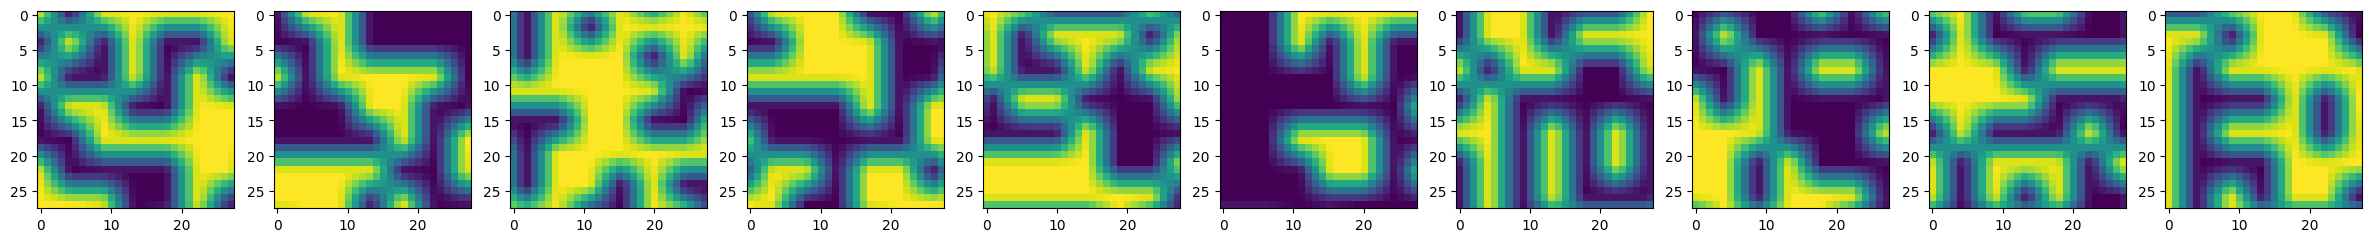

In [ ]:
from xailib.explainers.rise_explainer import RiseXAIImageExplainer

class Rise_model_wrapper():
    def __init__(self, bb, input_size):
        self.model = bb
        self.input_size = input_size

    def predict(self, images):
        return self.model(torch.tensor(images).reshape(-1,1,28,28).float()/255).detach().numpy()


model_ = Rise_model_wrapper(model, (28,28))
rise = RiseXAIImageExplainer(model_)


N = 10 # number of random masks
s = 8 # cell_size = input_shape / s
p1 = 0.5 # masking probability

rise.fit(N, s, p1)

F,ax=plt.subplots(1,10,figsize=(30,5))
for i in range(10):
    ax[i].imshow(rise.masks[i,:].reshape(28,28))

(2, 28, 28)


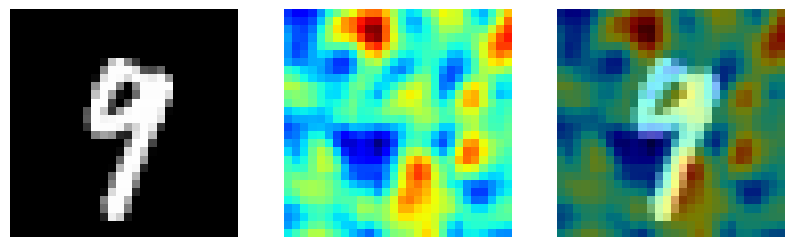

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(10,5))
img = factual.squeeze(0).squeeze(0).numpy()
N = 5000
s = 10
p1 = 0.5

rise.fit(N, s, p1)

sal = rise.explain(img.reshape(28,28,1)/255)
print(sal.shape)
rise_score = sal[1]

ax[0].imshow(img,cmap='gray')
ax[0].axis('off')

ax[1].imshow(rise_score,cmap='jet')
ax[1].axis('off')

ax[2].imshow(img,cmap='gray')
ax[2].imshow(rise_score,cmap='jet',alpha=0.5)
ax[2].axis('off');

## GradCAM

In [ ]:
print(list(model.modules())[2])

Sequential(
  (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (4): Dropout(p=0.5, inplace=False)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): ReLU()
)


In [ ]:
!pip install ttach

In [119]:
from xailib.explainers.gradcam_explainer import GradCAMImageExplainer
img = factual.squeeze(0)
explainer = GradCAMImageExplainer(model)
explainer.fit(list(model.modules())[2])
attr = explainer.explain(img.reshape(-1,1,28,28).float()/255,1,model_type='pytorch')
gradcam_pt_score = attr[0,:]

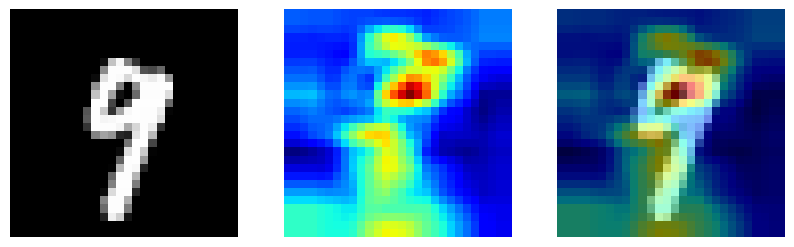

In [120]:
img = img.reshape(-1,1,28,28).float()/255
img = img.detach().view(28,28)

fig, ax = plt.subplots(1,3,figsize=(10,5))

ax[0].imshow(img,cmap='gray')
ax[0].axis('off')

ax[1].imshow(attr[0,:],cmap='jet')
ax[1].axis('off')

ax[2].imshow(img,cmap='gray')
ax[2].imshow(attr[0,:],cmap='jet',alpha=0.5)
ax[2].axis('off');

## GradCam++

In [121]:
from xailib.explainers.gradcam_explainer import GradCAMPlusPlusImageExplainer
img = factual.squeeze(0)
explainer = GradCAMPlusPlusImageExplainer(model)
explainer.fit(list(model.modules())[2])
attr = explainer.explain(img.reshape(-1,1,28,28).float()/255,1,model_type='pytorch')
gradcampp_pt_score = attr[0,:]

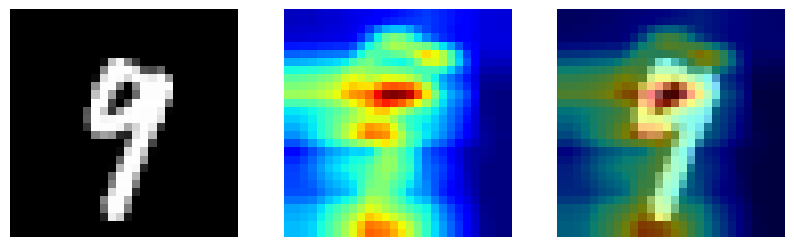

In [122]:
img = img.reshape(-1,1,28,28).float()/255
img = img.detach().view(28,28)

fig, ax = plt.subplots(1,3,figsize=(10,5))

ax[0].imshow(img,cmap='gray')
ax[0].axis('off')

ax[1].imshow(attr[0,:],cmap='jet')
ax[1].axis('off')

ax[2].imshow(img,cmap='gray')
ax[2].imshow(attr[0,:],cmap='jet',alpha=0.5)
ax[2].axis('off');

## RECAP

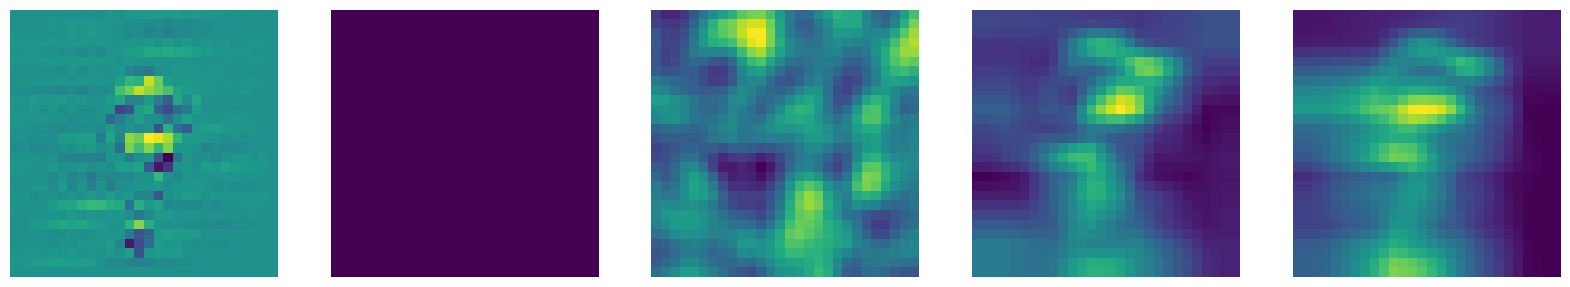

In [124]:
methods = [intgrad_pt_score,lime_score,rise_score,gradcam_pt_score,gradcampp_pt_score]
F, ax = plt.subplots(1,5,figsize=(20,5))
for i in range(5):
    ax[i].axis(False)
    ax[i].imshow(methods[i])

## ABELE

In [ ]:
import os
import skimage
from externals.ABELE.experiments.exputil import get_autoencoder
from externals.ABELE.experiments.exputil import get_dataset
import warnings
warnings.filterwarnings('ignore')

#disable eager execution in tensorflow 2.x for faster training time
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

# The dataset to use for training
# if you prefer to use yours load the data in two vector X_data and Y_data, set dataset variable to a custom name and custom_dataset to True
dataset = 'mnist'
custom_dataset = False
if not custom_dataset:
    X_train, Y_train, X_test, Y_test, use_rgb = get_dataset(dataset)

# The type of autoencoder to train ['aae','vae']
ae_name = 'aae'

# This script will save the models weights in the folder ./path/models/abele/dataset/ae_name
path = './'
path_aemodels = path + 'models/abele/%s/%s/' % (dataset,ae_name)
if not os.path.exists(path_aemodels):
    os.makedirs(path_aemodels)

# HYPER-PARAMETERS
#define the epochs and the batch size for which the autoencoder will be trained
epochs = 2000
batch_size = 64
#Print training summary every sample_interval step
sample_interval = 50

"""
 Get_autoencoder create the autoencoder class to train
 Arguments:
    X: dataset to use to train the ae
    ae_name: type of the autoencoder to train, only adversarial autoencoder (aae) and variational autoencoder (vae) are supported
    path_aemodels: path where to save the weights
    dataset: name of the dataset to use
    OPTIONAL:
    latent_dim: latent space dimension (only use if dataset is custom)
    hidden_dim: hidden dimension of the autoencoders layers (ex: 1024 will create two layers of 1024 hidden units) (only use if dataset is custom)
    num_filters: number of filter to use in the convolutional layers (only use if dataset is custom)
"""
ae = get_autoencoder(X_train, ae_name, path_aemodels, dataset)

""" Fit method
 Arguments:
    X: Dataset to use to train the ae
    epochs: Epochs to train
    batch_size
    sample interval (see before)
"""
# ae.fit(X_train, epochs=epochs, batch_size=batch_size, sample_interval=sample_interval)
# save the weights in the oath specified before
# ae.save_model()
# save also some sample images to test if the autoencoder is trained correctly
# ae.sample_images(epochs)

' Fit method\n Arguments:\n    X: Dataset to use to train the ae\n    epochs: Epochs to train\n    batch_size\n    sample interval (see before)\n'

In [ ]:
!pip install deap

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from skimage.color import gray2rgb, rgb2gray
from skimage import feature, transform

from xailib.explainers.abele_explainer import ABELEImageExplainer
from externals.ABELE.experiments.exputil import get_dataset
from externals.ABELE.experiments.exputil import get_autoencoder

from keras.src.saving import serialization_lib
serialization_lib.enable_unsafe_deserialization()

'''The above two lines added for the following error - ValueError: Requested the deserialization of a Lambda layer with a
Python `lambda` inside it. This carries a potential risk of arbitrary code execution and thus it is disallowed by default.
If you trust the source of the saved model, #you can pass `safe_mode=False` to the loading function in order
to allow Lambda layer loading. '''

import warnings
warnings.filterwarnings('ignore')

random_state = 0
dataset = 'mnist'
black_box = 'AB' #agnostic Black Box

# load autoencoder and black box
ae_name = 'aae'
path = './'
path_aemodels = path + 'models/abele/%s/%s/' % (dataset, ae_name)
#bb = tf.keras.models.load_model("./models/cnn_simple_mnist_no_pickle")
bb = model

# defining a functions for bb to return the class index value
def bb_predict(image):
    return np.argmax(model(torch.tensor(rgb2gray(image/255).reshape(-1,1,28,28)).float()).detach().numpy(),axis=1)
#def bb_predict(X):
#    X = X.astype(float)
#    Y = bb.predict(rgb2gray(X).reshape(-1,28,28,1))
#    return np.argmax(Y, axis=1)

# load data
X_train, Y_train, X_test, Y_test, _ = get_dataset(dataset)

# index Image 2 Explain
i2e = 80
img = factual.squeeze(0).numpy()
# time
start = time.time()

# create explainer
"""
Arguments:
    bb_predict: function which return the prediction of the blackbox in form index of the class
    class_name: name of the class used when printing rules (class_name: class_value)
    class_values: list of names of the classes (class_name: class_value)
    neigh_type: select the nighbourhood type,
                supportecd types:
                'gnt' : genetic
                'rnd' : random
                'hrg' : hybrid-random-genetic
                'gntp': genetic probabilistic
                'hrgp': hybrid probabilistic
    ocr: [0.1] other class values, ratio of other class from the one predicted in the neighbourhood
    kernel: [None] Kernel to weights the point in the nieghbourhood
    kernel_width : [None]
    autoencoder: Autoencoder to generate the latent space points
    use_rgb = [True] Set to True if the input images are rgb, False for grayscale
    filter_crules: [None] if True Prototypes are checked by the black box to be the same class of the query image
    random_state: set the seed of the random state
    verbose: True if you want to print more informations
    NEIGHBOURHOOD PARAMETERS: the following parameters are Neighbourhood specific and may not apply to all of the neighbourhood types
        valid_thr: [0.5] threshold to change class in the autoencoder disciminator
        alpha1: [0.5] weight of the feature similarity of the neighbourhood points
        alpha2: [0.5] weight of the target similarity of the neighbourhood points
        ngen: [100] number of generations of the genetic algorithm
        mutpb: [0.2] The probability of mutating an individual in the genetic algorithm
        cxpb: [0.5] The probability of mating two individuals in the genetic algorithm
        tournsize: [3] number of tournaments in the genetic algorithm
        hallooffame_ratio: [0.1] Fraction of exemplars to keep at every genetic generation
"""
config = {'bb_predict':bb_predict,
          'class_name':'class',
          'class_values':['%s' % i for i in range(len(np.unique(Y_test)))],
          'neigh_type':'hrg',
          'ocr':0.1, #other class ratio in the neighbourhood
          'kernel_width':None,
          'kernel':None,
          'autoencoder':autoencoder,
          'use_rgb':True,
          'filter_crules':False,
          'random_state':random_state,
          'verbose':True,
          'valid_thr':0.5,
          'alpha1':0.5,
          'alpha2':0.5,
          'ngen':100,
          'mutpb':0.2,
          'cxpb':0.5,
          'tournsize':3,
          'halloffame_ratio':0.1}


explainer = ABELEImageExplainer(bb)
explainer.fit(config)

#generate explanation
"""
generate an explanation for a given image
Arguments:
    img: the image to explain
    num_samples: [1000] number of samples to generate with the neighbourhood algorithm
    use_weights: [True] if weights the points using distance
Return:
Explanation object compose by several things
    rstr: string describing the rule
    cstr: string describing the counterfactual rule
    bb_pred: black box prediction of the image
    dt_pred: decisoon tree prediction
    fidelity: fidelity between black box and the decision tree
    limg: latent space representation of the image
"""
exp = explainer.explain(img, num_samples=300, use_weights=True)

# time
end = time.time()
print('--------------------------')
print('execution time: ',end - start,' sec')
print('e = {\n\tr = %s\n\tc = %s    \n}' % (exp.getRules(), exp.getCounterfactualRules()))
print('--------------------------')
print('bb prediction of the image: ',exp.exp.bb_pred,'dt prediction: ',exp.exp.dt_pred,'fidelity: ',exp.exp.fidelity)
print('latent space representation: ',exp.exp.limg)

generating neighborhood - hrg


AttributeError: 'Autoencoder' object has no attribute 'encode'